In [1]:
import netCDF4 as nc
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

Use the netCDF4 package to load NetCDF files (*.nc). You may have to install it separately. Usage is very simple, just point nc.Dataset to the data file and tell it to read the file rather than write to it.

In [2]:
data = nc.Dataset("plasim_samples/earth.nc","r")

The structure of a NetCDF4 Dataset is essentially a dictionary, with a set of strings as keys, which when handed to Dataset.variables, returns array-like data.

In [3]:
print "Code\tDimensions ([t],[z],[lat],[lon])"
for i in data.variables:
    print i,'\t',data.variables[i][:].shape

Code	Dimensions ([t],[z],[lat],[lon])
lon 	(64,)
lat 	(32,)
lev 	(10,)
time 	(12,)
sg 	(12, 32, 64)
ta 	(12, 10, 32, 64)
ua 	(12, 10, 32, 64)
va 	(12, 10, 32, 64)
hus 	(12, 10, 32, 64)
ps 	(12, 32, 64)
wap 	(12, 10, 32, 64)
wa 	(12, 10, 32, 64)
zeta 	(12, 10, 32, 64)
ts 	(12, 32, 64)
mrso 	(12, 32, 64)
snd 	(12, 32, 64)
prl 	(12, 32, 64)
prc 	(12, 32, 64)
prsn 	(12, 32, 64)
hfss 	(12, 32, 64)
hfls 	(12, 32, 64)
stf 	(12, 10, 32, 64)
psi 	(12, 10, 32, 64)
psl 	(12, 32, 64)
pl 	(12, 32, 64)
d 	(12, 10, 32, 64)
hur 	(12, 10, 32, 64)
mrro 	(12, 32, 64)
clw 	(12, 10, 32, 64)
cl 	(12, 10, 32, 64)
clt 	(12, 32, 64)
tas 	(12, 32, 64)
tsa 	(12, 32, 64)
lsm 	(12, 32, 64)
z0 	(12, 32, 64)
as 	(12, 32, 64)
rss 	(12, 32, 64)
rls 	(12, 32, 64)
rst 	(12, 32, 64)
rlut 	(12, 32, 64)
evap 	(12, 32, 64)
tso 	(12, 32, 64)
rsut 	(12, 32, 64)
ssru 	(12, 32, 64)
stru 	(12, 32, 64)
tso2 	(12, 32, 64)
sic 	(12, 32, 64)
sit 	(12, 32, 64)
snm 	(12, 32, 64)
sndc 	(12, 32, 64)
prw 	(12, 32, 64)
glac 	(12, 32, 64)


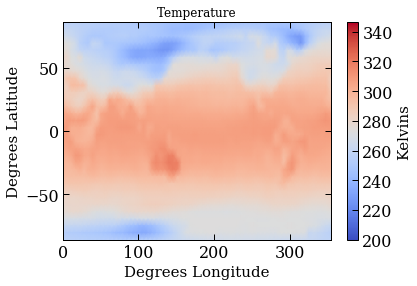

In [5]:
lts = data.variables['lat'][:]
lns = data.variables['lon'][:]
lons, lats = np.meshgrid(lns,lts)
t=plt.pcolormesh(lons,lats,data.variables['ts'][11,:],shading='Gouraud',cmap='coolwarm',vmin=200,vmax=346.3)
plt.xlabel('Degrees Longitude')
plt.ylabel('Degrees Latitude')
plt.title("Temperature")
plt.ylim(np.amin(lts),np.amax(lts))
plt.xlim(np.amin(lns),np.amax(lns))
c=plt.colorbar(t,label='Kelvins')


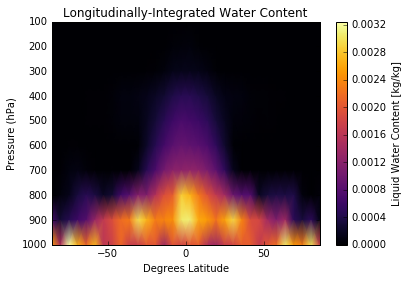

In [5]:
lvs = data.variables['lev'][:]
lats2,levs = np.meshgrid(lts,lvs)
w=plt.pcolormesh(lats2,levs,np.sum(data.variables['clw'][39,:],axis=2),shading='Gouraud',cmap='inferno')
plt.ylabel('Pressure (hPa)')
plt.xlabel('Degrees Latitude')
plt.title("Longitudinally-Integrated Water Content")
plt.ylim(np.amin(lvs),np.amax(lvs))
plt.xlim(np.amin(lts),np.amax(lts))
c=plt.colorbar(w,label='Liquid Water Content [kg/kg]')
plt.gca().invert_yaxis()

It can be instructive to view the data with the proper scaling, noting that we're talking about a spherical planet. The additional Matplotlib Basemap package allows us to plot the data as a Mollweide projection. This package needs to be installed separately, on top of the existing matplotlib installation.

In [6]:
from mpl_toolkits.basemap import Basemap

We also need to wrap the data--our data doesn't include both 360 degrees longitude and 0 degrees longitude, but we need it for a full Mollweide projection. So we define two functions for wrapping 2D and 3D data.

In [7]:
def wrap2d(datd,vals):
    modf=np.zeros(datd.ndim,dtype=int)
    modf[-1]=1
    dd=np.zeros(datd.shape+modf)
    dd[:,0:datd.shape[-1]]=datd
    dd[:,datd.shape[-1]]=vals
    return dd

def wrap3d(datd,vals):
    modf=np.zeros(datd.ndim,dtype=int)
    modf[-1]=1
    dd=np.zeros(datd.shape+modf)
    dd[:,:,0:datd.shape[-1]]=datd
    dd[:,:,datd.shape[-1]]=vals
    return dd

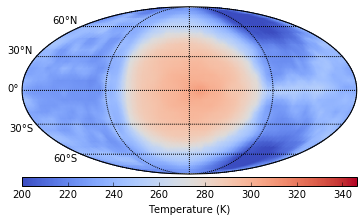

In [8]:
latsw=wrap2d(lats,lats[:,0])
lonsw=wrap2d(lons,360.0)
dataw=wrap2d(data.variables['ts'][39,:],data.variables['ts'][39,:,0])

m = Basemap(projection='moll',lon_0=0,resolution='c')
tm = m.pcolormesh(lonsw,latsw,dataw,shading='Gouraud',cmap='coolwarm',latlon=True,vmin=200,vmax=346.3)
#m.drawcoastlines()
pr=m.drawparallels(np.arange(-90.,120.,30.),labels=[1,0,0,1])
mr=m.drawmeridians(np.arange(-180,180.,90.))
cb = m.colorbar(tm,"bottom", size="5%", pad="2%",label="Temperature (K)")


Here we have meridians drawn at -180 degrees, -90 degrees, 0 degrees, 90 degrees, and 180 degrees. This nicely demarcates the terminator. We might also want to do a volumetric 3D rendering to see the actual structure of 3D data such as water concentration. To do so, we use the yt package, along with a ridiculous amount of fiddling with camera angle.

In [9]:
import yt
from yt.visualization.volume_rendering.transfer_function_helper import TransferFunctionHelper

We need to make the data fit into a somewhat larger cube so it doesn't get stretched too much. We'll also shuffle the data a bit so the substellar point (0 degrees longitude) is centered. We also need to scale it up and get rid of zeroes so that logarithmic color scaling/ray tracing will work.

In [10]:
datdat = np.zeros((10,32,64))
datdat[:,:,0:32] = data.variables['clw'][39,:,:,32:64]
datdat[:,:,32:64] = data.variables['clw'][39,:,:,0:32]

datd=wrap3d(datdat[:,:],datdat[:,:,0])
print datd.shape

grid=np.zeros((32,)+datd.shape[1:])
grid[11:21,:,:]=datd*1e8
nz=np.where(datd > 0)
nonzero=np.amin(datd[nz])*1e8
print nonzero
humidity=dict(density=grid+nonzero)
ds=yt.load_uniform_grid(humidity,grid.shape)

yt : [INFO     ] 2017-03-29 13:55:39,801 Parameters: current_time              = 0.0
yt : [INFO     ] 2017-03-29 13:55:39,802 Parameters: domain_dimensions         = [32 32 65]
yt : [INFO     ] 2017-03-29 13:55:39,802 Parameters: domain_left_edge          = [ 0.  0.  0.]
yt : [INFO     ] 2017-03-29 13:55:39,803 Parameters: domain_right_edge         = [ 1.  1.  1.]
yt : [INFO     ] 2017-03-29 13:55:39,803 Parameters: cosmological_simulation   = 0.0


(10, 32, 65)
0.0196990534995


We use viridis_r so that we see the qualitative edges clearly in the yellow, and interpret darker blue as having more water.

yt : [INFO     ] 2017-03-29 13:55:40,138 Setting default field to ('gas', 'density')
yt : [INFO     ] 2017-03-29 13:55:41,502 Rendering scene (Can take a while).
yt : [INFO     ] 2017-03-29 13:55:41,503 Creating volume
/usr/local/lib/python2.7/dist-packages/yt/utilities/amr_kdtree/amr_kdtree.py:311: RuntimeWarning: invalid value encountered in log10
  dds.append(np.log10(vcd[field].astype('float64')))


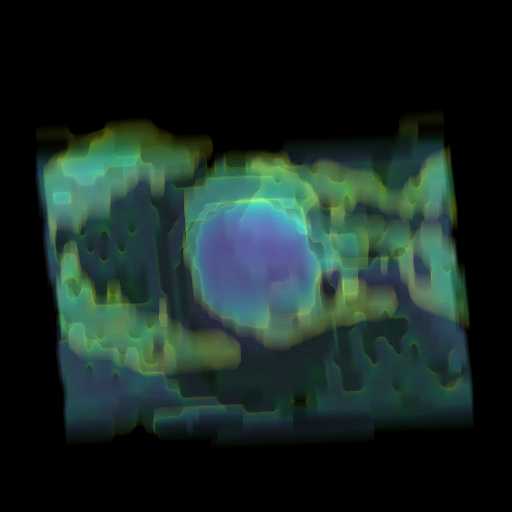

Water concentration (blue = more water)


In [11]:
def linramp(vals, minval, maxval):
    return (vals - vals.min())/(vals.max() - vals.min()) 

if np.amin(grid)==0:
    grid+=nonzero

sc = yt.create_scene(ds,lens_type='perspective')
bounds = (np.amin(grid+nonzero+10),np.amax(grid))
dmin=np.amin(grid)
dmax=np.amax(grid+nonzero)
#tf = yt.ColorTransferFunction(np.log10(bounds))
#tf.add_layers(20, colormap='viridis_r')
##tf.map_to_colormap(np.log10(dmin),np.log10(dmax), colormap='plasma',
##                   scale_func=linramp)
#source = sc[0]
#source.tfh.tf=tf
#source.tfh.set_bounds(bounds)
#source.tfh.tf=tf

source = sc[0]
source.tfh = TransferFunctionHelper(ds)
source.tfh.set_field('density')


source.tfh.set_bounds(bounds)
source.tfh.set_log(True)
source.tfh.build_transfer_function()

source.tfh.tf.map_to_colormap(dmin, dmax, colormap='viridis_r')

cam=sc.add_camera(ds)
cam.zoom(1.2)
#cam.rotate(np.pi/8.0, np.array([0.0, 1.0, 0.0]))
cam.rotate(np.pi/2.0, np.array([1.0, 0.0, 0.0]))
cam.rotate(-np.pi/8.0, np.array([0.0, 1.0, 0.0]))
cam.rotate(np.pi/1.2, np.array([0.0,1.0,0.0]),rot_center=np.array([0.0, 0.0, 0.0]))
cam.rotate(-np.pi*0.45, np.array([1.0,0.0,0.0]),rot_center=np.array([0.0, 0.0, 0.0]))
cam.rotate(-np.pi*0.2, np.array([0.0,0.0,1.0]),rot_center=np.array([0.0, 0.0, 0.0]))
cam.rotate(-np.pi*0.2, np.array([1.0,-0.5,0.0]),rot_center=np.array([0.0, 0.0, 0.0]))
cam.rotate(-np.pi, np.array([0.0,0.0,1.0]),rot_center=np.array([0.0, 0.0, 0.0]))
cam.rotate(np.pi/1.5, np.array([0.0,1.0,0.0]),rot_center=np.array([0.0, 0.0, 0.0]))
cam.rotate(np.pi*0.3, np.array([1.0,0.0,-0.2]),rot_center=np.array([0.0, 0.0, 0.0]))
cam.rotate(np.pi*0.1, np.array([1.0,0.0,0.0]),rot_center=np.array([0.0, 0.0, 0.0]))
cam.rotate(-np.pi*1.4, np.array([0.8,-0.4,-0.2]),rot_center=np.array([0.0, 0.0, 0.0]))
cam.rotate(np.pi*0.4, np.array([1.0,0.0,0.0]))
cam.rotate(np.pi*0.1, np.array([0.0,-0.8,1.0]),rot_center=np.array([0.0, 0.0, 0.0]))
cam.rotate(np.pi*0.1, np.array([0.7,-1.0,1.5]),rot_center=np.array([0.0, 0.0, 0.0]))
cam.rotate(np.pi*0.05, np.array([0.0,0.0,1.0]),rot_center=np.array([0.0, 0.0, 0.0]))
#source.set_log(True)  
source.tfh.grey_opacity=False
#source.tfh.plot(profile_field='density')
source.tfh.plot('transfer_function.png', profile_field='density')
sc.show()
print "Water concentration (blue = more water)"